## FTLE Computation and Comparison with Tracers

The notebook takes SSH (Sea Surface Height) maps and tracers (SST (Sea Surface Temperature), salinity, chlorophyllis) as input. It computes FTLE (Final Time Liaponov Exponents) from the trajectories and geostrophical currents computed with Lagrangians.

The aim is to compare these results with tracers, compute their correlation and therefore evaluate the performance of various models.

In [17]:
# Import libraries

import numpy as np
import jaxparrow
import xarray as xr
import jax.numpy as jnp
import jaxparrow as jpw
import matplotlib.pyplot as plt

### GEOSTROPHIC CURRENTS

In [12]:
xihe_ssh = xr.open_dataset('data/xihe_ssh.nc')
xihe_sst = xr.open_dataset('data/xihe_thetao.nc')


sst_pred = jnp.asarray(xihe_sst.prediction.data)
mask = ~(jnp.isfinite(sst_pred[0,0,:,:]))

In [3]:
glorys_data = xr.open_dataset('data/glorys_data.nc')
glorys_data.var

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 176MB
Dimensions:    (depth: 1, latitude: 2041, longitude: 4320, time: 1)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * time       (time) datetime64[ns] 8B 2021-06-30
Data variables:
    so         (time, depth, latitude, longitude) float32 35MB ...
    thetao     (time, depth, latitude, longitude) float32 35MB ...
    uo         (time, depth, latitude, longitude) float32 35MB ...
    vo         (time, depth, latitude, longitude) float32 35MB ...
    zos        (time, latitude, longitude) float32 35MB ...
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       MERCATOR OCEAN
    source:            MERCATOR GLORYS12V1
    history:           2023/06/01 16:20:05 MERCATOR O

In [4]:
def get_uv_matrix(var_pred, lon_mesh, lat_mesh):

    ug_jpw_u, vg_jpw_v, lat_u, lon_u, lat_v, lon_v = jpw.geostrophy(var_pred, lat_mesh, lon_mesh, mask)

    return ug_jpw_u, vg_jpw_v
    

In [5]:
def get_uv_xihe(data_source, var_name='ssh', lat_name='latitude', lon_name='longitude'):

    lon_mesh, lat_mesh = jnp.meshgrid(data_source[lon_name].data[0], data_source[lat_name].data[0])
    var_pred = jnp.asarray(data_source[var_name].data)[0,0,:,:]

    u,v = get_uv_matrix(var_pred, lon_mesh, lat_mesh)
    return u,v

In [6]:
def get_uv_glorys(data_source, var_name='ssh', lat_name='latitude', lon_name='longitude'):

    lon_mesh, lat_mesh = jnp.meshgrid(data_source[lon_name].data, data_source[lat_name].data)
    var_pred = jnp.asarray(data_source[var_name].data[0])

    u,v = get_uv_matrix(var_pred, lon_mesh, lat_mesh)
    return u,v


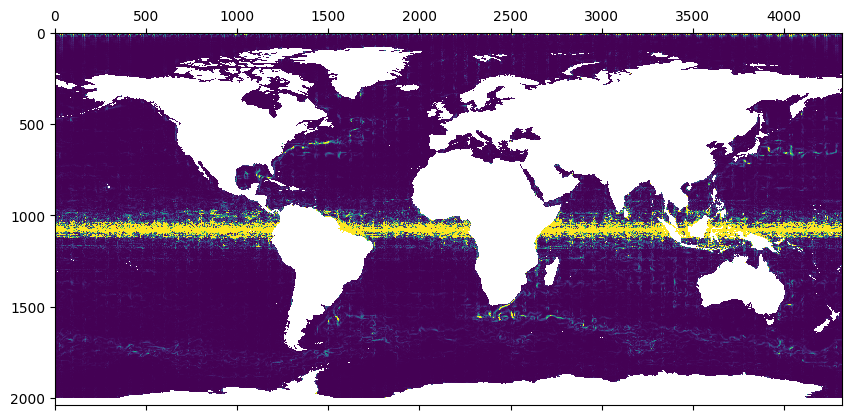

In [15]:
xihe_u, xihe_v = get_uv_xihe(xihe_ssh, var_name='prediction')
to_show = (xihe_u**2+xihe_v**2)[::-1]
plt.matshow(to_show, vmin=0, vmax=3)

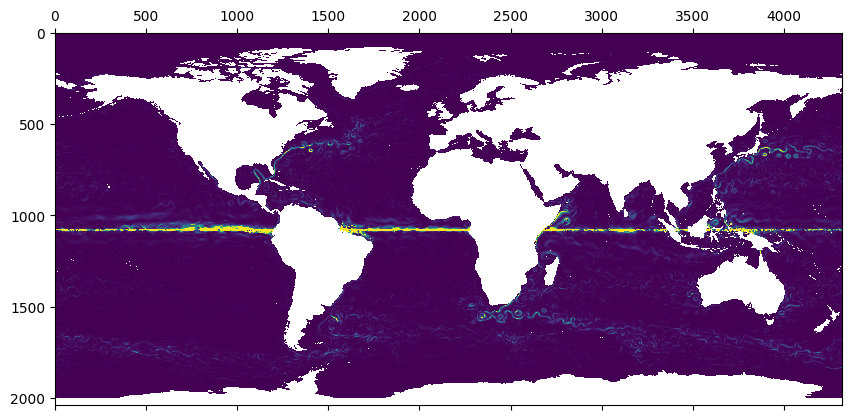

In [16]:
xihe_u, xihe_v = get_uv_glorys(glorys_data, var_name='zos')
to_show = (xihe_u**2+xihe_v**2)[::-1]
plt.matshow(to_show, vmin=0, vmax=3)